In [28]:
import os, os.path, re, imp
import numpy as np
from collections import Counter
from sys import getsizeof
import time
from sklearn.preprocessing import normalize, scale, MinMaxScaler
from sklearn.cluster import *
from code.modules.extract_model_tokens_encodings import extract_tokens
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import code.Parametrizer as Parametrizer

from code.Primitives import *
%matplotlib inline

label = open_apple
data.shape =  (6400, 2)
0 model =  plus2_(sinla_(times2_(parabola_(normal_(expl_(X[0]))),sinla_(X[0]))),times2_(X[0],parabola_(X[0])))
model = plus2_(sinla_(w[1],w[2],times2_(parabola_(w[3],w[4],w[5],normal_(w[6],w[7],expl_(w[8],w[9],x))),sinla_(w[10],w[11],x))),times2_(x,parabola_(w[12],w[13],w[14],x)))
w = np.array([ 0.        , -0.70309452,  3.50000086,  0.44512984, -2.21178237,
        1.        , -0.75      ,  2.84774636, -0.03239363,  2.77089991,
       -0.16205705,  3.5       , -0.49219771,  0.78031283,  1.        ])
0.857780252563


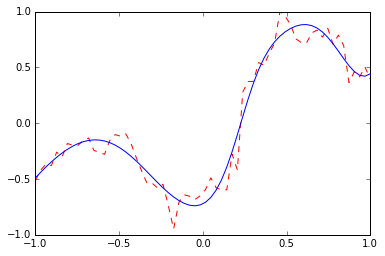

1 model =  plus2_(times2_(normal_(expl_(normal_(X[0]))),frac2_(linear_(sinha_(X[0])),linear_(X[0]))),linear_(sinha_(X[0])))
model = plus2_(times2_(normal_(w[1],w[2],expl_(w[3],w[4],normal_(w[5],w[6],x))),frac2_(linear_(w[7],w[8],sinha_(w[9],w[10],x)),linear_(w[11],w[12],x))),linear_(w[13],w[14],sinha_(w[15],w[16],x)))
w = np.array([  0.        ,   0.21172788,   0.53437143,  -3.31622616,
         5.        ,  -0.39995395,   0.17870134,   8.57116709,
         2.66730659,   3.75814417,   5.1       ,  16.47816314,
         0.2       ,  -0.40902156,   0.29015837,  -1.03552076,   5.67003722])
0.75593045736


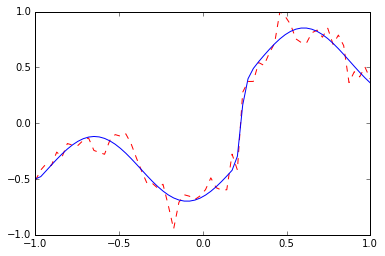

2 model =  plus2_(times2_(parabola_(parabola_(normal_(X[0]))),normal_(expl_(X[0]))),linear_(sinha_(X[0])))
model = plus2_(times2_(parabola_(w[1],w[2],w[3],parabola_(w[4],w[5],w[6],normal_(w[7],w[8],x))),normal_(w[9],w[10],expl_(w[11],w[12],x))),linear_(w[13],w[14],sinha_(w[15],w[16],x)))
w = np.array([  0.        ,  -0.14502245,   0.40995188,  31.77389412,
         1.11879341,  -3.99999976,   3.40818703,  -0.35149326,
         1.5616108 ,   0.18254077,   0.05      ,  -1.98774335,
         4.9999994 ,   0.71647692,   0.2       ,   0.57023071,  11.46906101])
0.870750890611


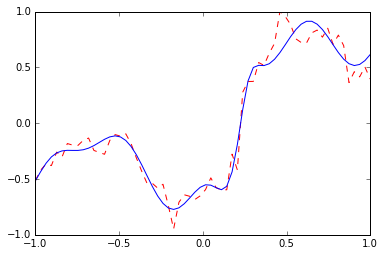

3 model =  plus2_(times2_(parabola_(X[0]),normal_(X[0])),linear_(times2_(parabola_(normal_(expl_(X[0]))),sinla_(X[0]))))
model = plus2_(times2_(parabola_(w[1],w[2],w[3],x),normal_(w[4],w[5],x)),linear_(w[6],w[7],times2_(parabola_(w[8],w[9],w[10],normal_(w[11],w[12],expl_(w[13],w[14],x))),sinla_(w[15],w[16],x))))
w = np.array([ 0.        ,  0.28408787, -0.82660329,  2.83673535,  0.21163759,
        0.06116325, -0.61872721,  4.45948311, -0.21749729, -3.80465371,
        5.21173675, -0.40281878,  0.05      , -4.31448294,  2.98895078,
        1.13018469,  3.5       ])
0.767167012739


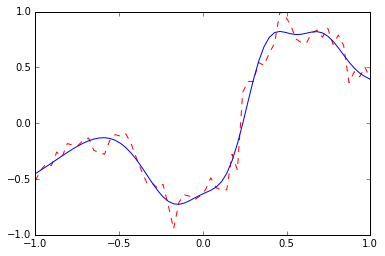

4 model =  times2_(normal_(sinla_(X[0])),times2_(parabola_(X[0]),normal_(sinla_(normal_(X[0])))))
model = times2_(normal_(w[1],w[2],sinla_(w[3],w[4],x)),times2_(parabola_(w[5],w[6],w[7],x),normal_(w[8],w[9],sinla_(w[10],w[11],normal_(w[12],w[13],x)))))
w = np.array([ 0.        , -0.09180302,  0.82084104, -1.10362446,  3.98583197,
       -1.12469177,  4.        ,  3.13492636, -0.66479895,  0.95375851,
       -0.72248324,  3.98160054,  0.25862814,  0.7426165 ])
0.743894087779


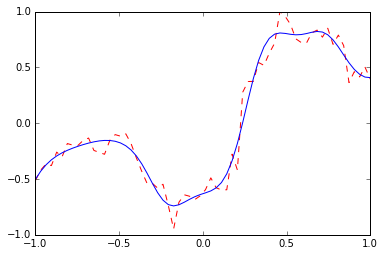

5 model =  plus2_(times2_(parabola_(normal_(sinla_(X[0]))),normal_(expl_(X[0]))),linear_(sinha_(X[0])))
model = plus2_(times2_(parabola_(w[1],w[2],w[3],normal_(w[4],w[5],sinla_(w[6],w[7],x))),normal_(w[8],w[9],expl_(w[10],w[11],x))),linear_(w[12],w[13],sinha_(w[14],w[15],x)))
w = np.array([  0.        ,  -1.05991313,   3.99999505,   8.26619247,
        -0.38622414,   6.04884178,  -0.32655997,   3.5       ,
         0.28507969,   0.12425961,  -1.42849299,   4.51692047,
         0.71993911,   0.2       ,   0.44651522,  11.60578502])
0.882075141516


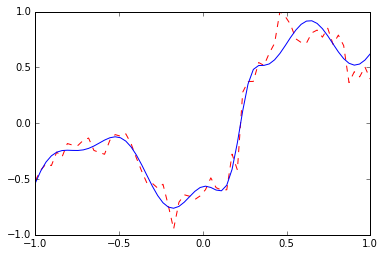

6 model =  plus2_(times2_(parabola_(normal_(normal_(X[0]))),normal_(expl_(X[0]))),linear_(sinha_(X[0])))
model = plus2_(times2_(parabola_(w[1],w[2],w[3],normal_(w[4],w[5],normal_(w[6],w[7],x))),normal_(w[8],w[9],expl_(w[10],w[11],x))),linear_(w[12],w[13],sinha_(w[14],w[15],x)))
w = np.array([ 0.        , -0.59538228, -2.77421066,  1.        ,  0.79732261,
        0.59245674,  0.25416554,  0.42186504,  1.        ,  0.82719528,
       -0.59611955,  5.        ,  0.55539356,  0.28859069, -1.75594126,
        5.56777622])
0.737087741637


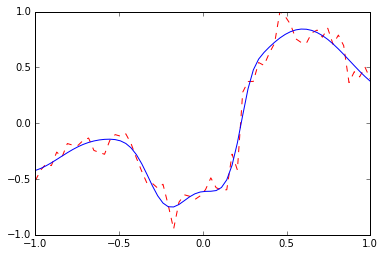

7 model =  plus2_(times2_(parabola_(normal_(X[0])),normal_(expl_(X[0]))),linear_(sinha_(normal_(X[0]))))
model = plus2_(times2_(parabola_(w[1],w[2],w[3],normal_(w[4],w[5],x)),normal_(w[6],w[7],expl_(w[8],w[9],x))),linear_(w[10],w[11],sinha_(w[12],w[13],normal_(w[14],w[15],x))))
w = np.array([ 0.        , -4.03432502, -0.84978614,  2.3672251 ,  0.05951688,
        0.68848102,  0.95907688,  0.27700596, -0.24797579,  3.17133972,
        0.51320099,  0.32845246,  3.70586147,  5.1       ,  0.05717674,
        0.8557382 ])
0.752661611771


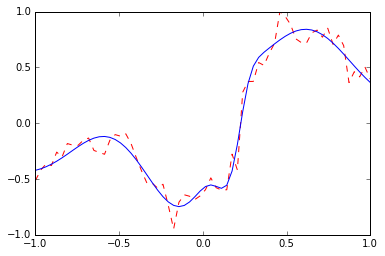

8 model =  plus2_(times2_(parabola_(X[0]),normal_(normal_(X[0]))),linear_(sinha_(X[0])))
model = plus2_(times2_(parabola_(w[1],w[2],w[3],x),normal_(w[4],w[5],normal_(w[6],w[7],x))),linear_(w[8],w[9],sinha_(w[10],w[11],x)))
w = np.array([ 0.        ,  0.2325289 ,  2.46461675,  1.        ,  0.97015625,
        2.13245103, -0.15796381,  0.08978845, -0.26185079,  0.49928529,
       -1.05335501,  5.1       ])
0.758046492499


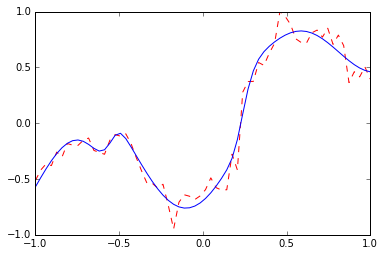

9 model =  plus2_(times2_(parabola_(X[0]),normal_(sinha_(X[0]))),linear_(sinha_(X[0])))
model = plus2_(times2_(parabola_(w[1],w[2],w[3],x),normal_(w[4],w[5],sinha_(w[6],w[7],x))),linear_(w[8],w[9],sinha_(w[10],w[11],x)))
w = np.array([ 0.        ,  3.56661419,  4.        ,  4.53567593, -0.35923115,
        4.2380939 ,  0.26444753,  7.66959087, -1.03591022,  0.43508645,
       -0.94997285,  6.28433573])
0.767046036731


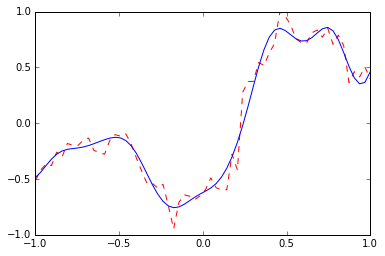

10 model =  neg_(parabola_(plus2_(expl_(X[0]),linear_(times2_(expl_(X[0]),normal_(sinla_(normal_(X[0]))))))))
model = neg_(parabola_(w[1],w[2],w[3],plus2_(expl_(w[4],w[5],x),linear_(w[6],w[7],times2_(expl_(w[8],w[9],x),normal_(w[10],w[11],sinla_(w[12],w[13],normal_(w[14],w[15],x))))))))
w = np.array([ 0.        , -0.82755368, -0.11653   ,  1.47065458, -2.3862764 ,
        2.18900131, -1.05489164,  1.14706405, -1.44126771,  0.87820196,
        1.        ,  0.63710435, -5.        ,  4.68188055,  0.65018168,
        0.70067181])
0.75405186961


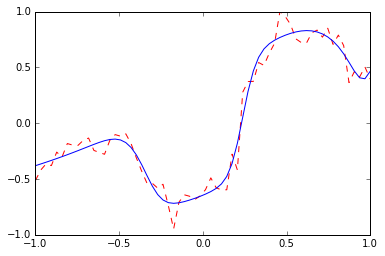

11 model =  plus2_(times2_(parabola_(X[0]),normal_(times2_(X[0],sinla_(sinha_(normal_(X[0])))))),linear_(sinha_(X[0])))
model = plus2_(times2_(parabola_(w[1],w[2],w[3],x),normal_(w[4],w[5],times2_(x,sinla_(w[6],w[7],sinha_(w[8],w[9],normal_(w[10],w[11],x)))))),linear_(w[12],w[13],sinha_(w[14],w[15],x)))
w = np.array([ 0.        , -0.03924337,  1.65944544,  1.64909934,  0.36973237,
        1.11709094,  2.75142123,  4.82564437,  2.34300411,  5.1       ,
       -0.06052581,  1.21864075, -0.23426918,  0.40383334, -1.59268688,
        5.1       ])
0.775049724602


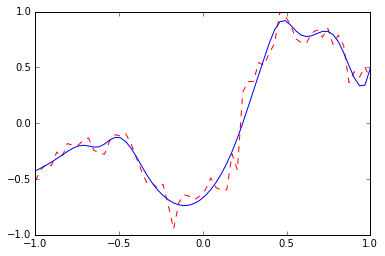

12 model =  plus2_(times2_(parabola_(X[0]),normal_(times2_(X[0],sinla_(sinha_(normal_(X[0])))))),linear_(X[0]))
model = plus2_(times2_(parabola_(w[1],w[2],w[3],x),normal_(w[4],w[5],times2_(x,sinla_(w[6],w[7],sinha_(w[8],w[9],normal_(w[10],w[11],x)))))),linear_(w[12],w[13],x))
w = np.array([ 0.        , -0.58634529,  1.17950514,  1.        ,  0.48217226,
        0.66580594, -1.04943967,  3.5       ,  2.53362342,  5.10002879,
       -0.4350629 ,  0.83643022,  0.12764892,  0.21353324])
1.77649037328


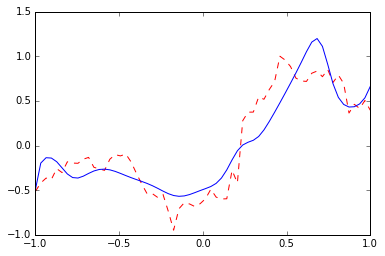

13 model =  times2_(normal_(sinla_(X[0])),times2_(parabola_(parabola_(normal_(expl_(X[0])))),expl_(X[0])))
model = times2_(normal_(w[1],w[2],sinla_(w[3],w[4],x)),times2_(parabola_(w[5],w[6],w[7],parabola_(w[8],w[9],w[10],normal_(w[11],w[12],expl_(w[13],w[14],x)))),expl_(w[15],w[16],x)))
w = np.array([ 0.        ,  0.04675004,  0.60104677,  0.51805249,  3.54030976,
       -0.45113715, -0.47139876,  2.24172757, -0.45050565, -1.36971588,
        2.0334047 ,  0.56820109,  0.93915467, -0.35885624,  2.10775139,
        0.44615127,  0.5       ])
0.78039796534


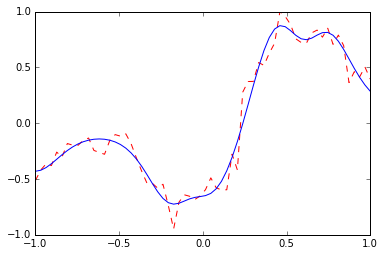

14 model =  plus2_(times2_(parabola_(X[0]),normal_(sinla_(X[0]))),linear_(sinha_(X[0])))
model = plus2_(times2_(parabola_(w[1],w[2],w[3],x),normal_(w[4],w[5],sinla_(w[6],w[7],x))),linear_(w[8],w[9],sinha_(w[10],w[11],x)))
w = np.array([  0.00000000e+00,   2.90569786e+02,   3.77035522e+00,
         6.38140352e+00,   1.02027700e-02,   5.33986724e+00,
         1.53955638e-01,   3.81040371e+00,  -5.00000000e+01,
         4.99999999e+00,  -1.27785396e+00,   7.50602042e+00])
0.785947193737


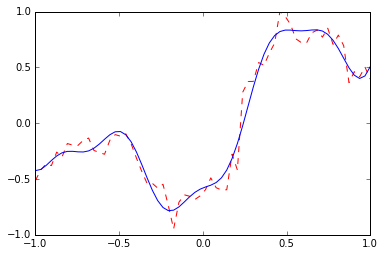

15 model =  plus2_(times2_(parabola_(X[0]),sinha_(plus2_(X[0],parabola_(normal_(X[0]))))),linear_(sinha_(X[0])))
model = plus2_(times2_(parabola_(w[1],w[2],w[3],x),sinha_(w[4],w[5],plus2_(x,parabola_(w[6],w[7],w[8],normal_(w[9],w[10],x))))),linear_(w[11],w[12],sinha_(w[13],w[14],x)))
w = np.array([ 0.        ,  0.11168046,  1.23011273,  1.31021797,  0.03773354,
        8.13286167,  0.48163102,  0.3742624 ,  1.00000275,  0.19933759,
        1.29324255, -0.37230704,  0.27596456, -0.7479912 ,  5.80846974])
0.787302694391


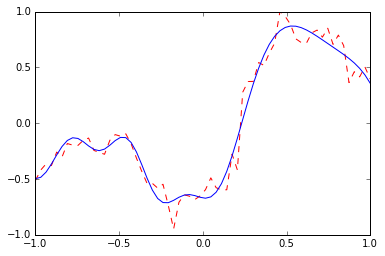

16 model =  times2_(normal_(sinla_(X[0])),times2_(parabola_(X[0]),linear_(sinha_(X[0]))))
model = times2_(normal_(w[1],w[2],sinla_(w[3],w[4],x)),times2_(parabola_(w[5],w[6],w[7],x),linear_(w[8],w[9],sinha_(w[10],w[11],x))))
w = np.array([  0.        ,   1.        ,   1.58572974,   0.78823635,
         3.91517348,  -0.58945421,   1.9784442 ,   2.0818688 ,
         2.35066907,   0.6310656 ,  -1.12214417,  10.55379106])
0.790233921402


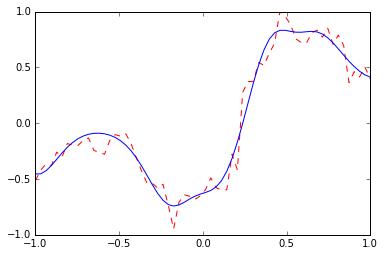

In [30]:
%run ValidateFinalModel.py 'specific_segment' 'open_apple' 1

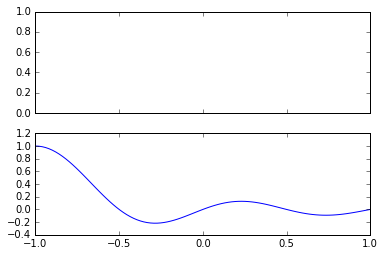

In [26]:
#w = [0.75945128579027477, 1.8257602509301276, 0.47967188925467663, 1.6194614328457326, 0.4164207414652753, 0.73103167165388483, 0.98798319227210962, 0.98412347875238682]
def sinc_(w0, w1, x):
    sinc_.NumParam = 2
    sinc_.NumVars = 1
    sinc_.InitParams = [0,1]
    sinc_.BoundsParams = ([-1,-1],[0.5,1])

    return np.sinc(w1 * (x - w0))
    
w = np.array([ 0.        , -0.36296506,  0.24764214,  1.        ,  0.51329505,
        1.16573977,  0.05446038, -1.92731684,  2.42279041,  0.06568878,
        0.78853809])
x = np.linspace(-1,1,100)
#plt.plot(x,x-normal_(w[0],w[1],normal_(w[2],w[3],normal_(w[4],w[5],normal_(w[6],w[7],x)))))
#model = 'linear_(w[0],w[1],normal_(w[2],w[3],normal_(w[4],w[5],sinla_(w[6],w[7],sinha_(w[8],w[9],x)))))'
#model = 'parabola_(w[0],w[1],w[2],normal_(w[3],w[4],inv_(sinla_(w[5],w[6],normal_(w[7],w[8],x)))))'
model = parabola_(w[0],w[1],w[2],lnl_(w[3],w[4],parabola_(w[5],w[6],w[7],x)))
w = [-1, 2, 2.9381087109028354, 0.63497754961878039, 3.9754388501569062, 3.5131750804291748, 10.60747766141427784, 9.1731258548658052]
#plt.plot(x,normal_(w[4],w[5],sinla_(w[6],w[7],normal_(w[8],w[9],x))))
f, axarr = plt.subplots(2, sharex=True)
axarr[1].plot(x, sinc_(w[0],w[1],x))

plt.show()

In [23]:
from pyparsing import nestedExpr
txt = "(linear_(linear_(normal_(normal_(sinha_(X[0]))))))"
nst = nestedExpr('(',')').parseString(txt).asList()
import itertools
merged = list(itertools.chain(*nst))
merged

(linear_&linear_&normal_&normal_&sinha_


['linear_', ['linear_', ['normal_', ['normal_', ['sinha_', ['X[0]']]]]]]

In [39]:
from sklearn import datasets
X, y = datasets.make_regression(int(1e5))
print("{:,}".format(X.nbytes))

80,000,000


** Sort rules in 'data/rules.txt' for convenience **

In [26]:
file = open('/home/kuluandrej/Ipython3_notebook_projects/MVR_py/data/rules.txt','r')
file[-1].extend('\n')
lines = file.readlines()
lines_sorted = sorted(lines)
file.close()
file = open('/home/kuluandrej/Ipython3_notebook_projects/MVR_py/data/rules.txt','w')
file.write(''.join(lines_sorted))
file.close()

['atana_(linear_(x0)) atana_(x0)\n', 'atana_(mult_(x0)) atana_(x0)\n', 'atana_(plus2_(x0,x0)) atana_(x0)\n', 'atana_(plus_(x0)) atana_(x0)\n', 'expl_(linear_(x0)) expl_(x0)\n', 'expl_(lnl_(x0)) linear_(x0)\n', 'expl_(mult_(x0)) expl_(x0)\n', 'expl_(plus2_(x0,x0)) expl_(x0)\n', 'expl_(plus_(x0)) expl_(x0)\n', 'hyperbola_(inv_(x0)) mult_(x0)\n', 'inv_(expl_(x0)) expl_(x0)\n', 'inv_(hyperbola_(x0)) mult_(x0)\n', 'inv_(inv_(x0)) x0\n', 'inv_(mult_(x0)) inv_(x0)\n', 'linear_(linear_(x0)) linear_(x0)\n', 'linear_(mult_(x0)) linear_(x0)\n', 'linear_(parabola_(x0)) parabola_(x0)\n', 'linear_(plus_(x0)) linear_(x0)\n', 'lnl_(expl_(x0)) linear_(x0)\n', 'lnl_(linear_(x0)) lnl_(x0)\n', 'lnl_(mult_(x0)) lnl_(x0)\n', 'lnl_(normal_(x0)) parabola_(x0)\n', 'lnl_(plus2_(x0,x0)) lnl_(x0)\n', 'lnl_(plus_(x0)) lnl_(x0)\n', 'mult_(hyperbola_(x0)) hyperbola_(x0)\n', 'mult_(hyperbola_(x0)) mult_(x0)\n', 'mult_(linear_(x0)) linear_(x0)\n', 'mult_(mult_(x0)) mult_(x0)\n', 'mult_(parabola_(x0)) parabola_(x0)\n',

In [ ]:
ax2 + bx + c -> 2ax + b = 0 -> x0 = -b  in [-2a,2a]

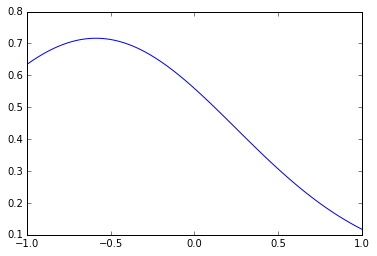

In [52]:
def cosh_(w0, w1, x):
    cosh_.NumParam = 2
    cosh_.NumVars = 1

    return np.cosh(x * (0.5 + abs(w1)) + w0)

x = np.linspace(-1,1,100)
plt.plot(x,normal_(w[8],w[9],x))
plt.show()

In [24]:
a = ([],[])

[1, 2, 2, 3, 4]

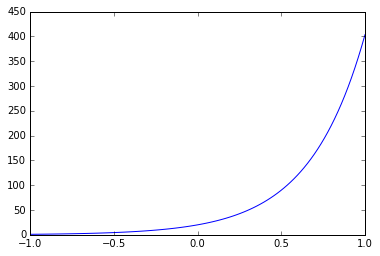

In [29]:
def expl_(w0, w1, x):
    expl_.NumParam = 2
    expl_.NumVars = 1
    return np.exp(x * w1 + w0)
w0 = 3
w1 = 3
x = np.linspace(-1,1,100)
y = expl_(w0, w1, x)
plt.plot(x,y)

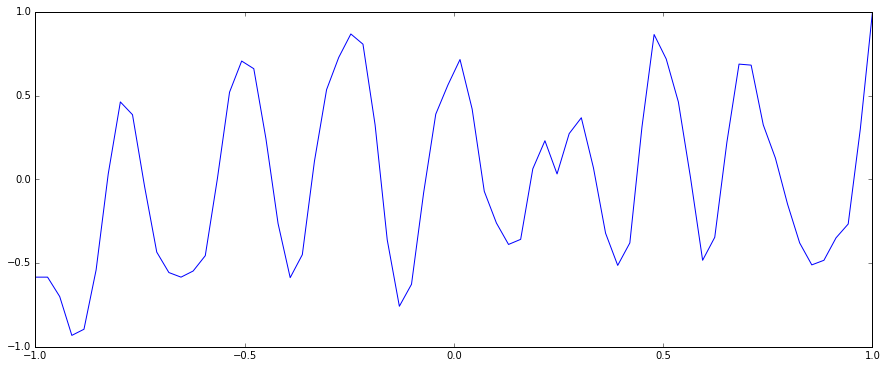

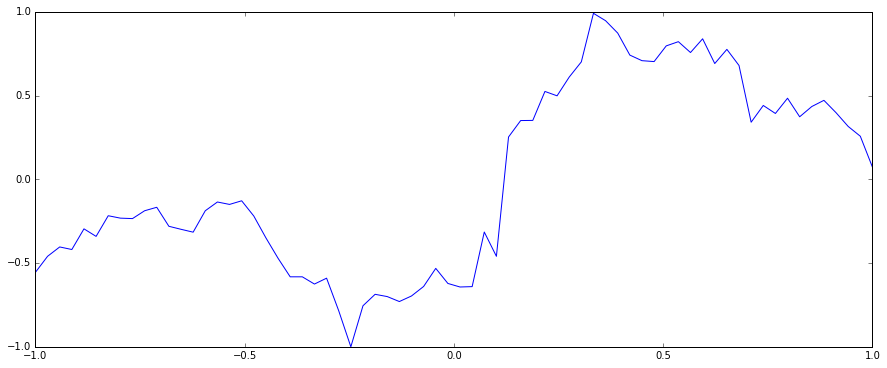

In [40]:
plt.figure(figsize = (15,6))

b = np.loadtxt('/home/kuluandrej/Ipython3_notebook_projects/MVR_py/ts_processing/heart_rate.txt')
segment = 0
length = 70
x = np.linspace(-1,1,length)
y = b[segment*length:(segment + 1)*length]
y = y - np.mean(y, axis = 0)
y = np.divide(y, np.max(np.abs(y), axis=0))
plt.plot(x, y)
plt.figure(figsize = (15,6))
b = np.loadtxt('/home/kuluandrej/Ipython3_notebook_projects/MVR_py/ts_processing/open_apple.txt')
segment = 0
length = 70
x = np.linspace(-1,1,length)
y = b[segment*length:(segment + 1)*length]
y = y - np.mean(y, axis = 0)
y = np.divide(y, np.max(np.abs(y), axis=0))
plt.plot(x, y)

** Write specified number of samples to ts_processing text-files **

In [122]:
ts_labels = ['chest_volume', 'heart_rate', 'oxygen_concentration', 'open_apple']
file_path = 'ts_processing/'
number_of_rows = 6400
for ts_label in ts_labels:
    array = np.loadtxt(file_path + ts_label + '_full.txt')
    np.savetxt(file_path + ts_label + '.txt', array[0:number_of_rows], fmt = '%.3f')

In [123]:
dataset = pd.read_csv('/home/kuluandrej/cafedra2015-2016/Experiments on Machine Learning/Datasets/WIKI-AAPL.csv')
time_series = dataset['Open']
backup_time_series = time_series

In [48]:
import re
b = 'plus2_(lnl_(linear_(x0)),atana_(linear_(x0)))'
re.sub(r'x(\d+)', r'X[\1]', b)
handle = re.sub(r'X\[(\d+)\]', r'x\1', 'x0')
handle

'x0'

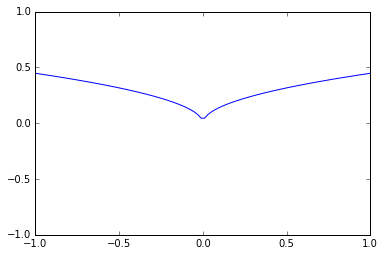

In [15]:
x = np.linspace(-1,1,100)
w0 = 0
w1 = 0.2

def sqrtl_(w0, w1, x):
    sqrtl_.NumParam = 2
    sqrtl_.NumVars = 1

    return np.sqrt(np.abs(x * w1 + w0))

plt.plot(x, sqrtl_(w0, w1, x))
plt.axis([-1, 1, -1, 1])
plt.show()

In [25]:
files_path = 'ts_processing/'
ts_labels = ['chest_volume', 'heart_rate', 'oxygen_concentration']
ts_labels = sorted(ts_labels)

number_ts_pieces = len(os.listdir(files_path)) / len(ts_labels)
# if the number is not divided 
if abs(number_ts_pieces - round(number_ts_pieces)) > 0:
    print('ERROR: invalid number of files in ', files_path)
else:
    number_ts_pieces = int(number_ts_pieces)    

def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):    
    return [ atoi(c) for c in re.split('(\d+)', text) ]

file_names = sorted(os.listdir(files_path), key=natural_keys)

ERROR: invalid number of files in  ts_processing/


In [26]:
# set of labels of ts to classify
# labels = chest_volume, heart_rate, oxygen_concentration
labels = ['chest_volume', 'heart_rate', 'oxygen_concentration']
# locations of the ts
root_path = '/MVR_py/ts_processing/'
# extension of files containing data about ts
extension = '.txt'
# folder for output files
where_to_store_models = 'collected_models2/'
# specifies number of segments for ts to be split on
number_of_segments = 340

def retrieve_ts(label):
    
    dataset_filename     = '/data/data_to_fit.txt'
    init_models_filename = '/data/init_models.txt'
    
    
    
    DATA_LOCAL_PATH = root_path
    script_dir = os.path.dirname('__file__')
    parent_dir = os.path.abspath(os.path.join(script_dir, os.pardir))
    DATA_FULL_PATH = parent_dir + DATA_LOCAL_PATH + label + extension
    # retrieve the data to fit from the specified file
    data_to_fit = np.loadtxt(DATA_FULL_PATH, delimiter = ',')
    data_to_fit = np.vstack((data_to_fit, np.linspace(0,1, len(data_to_fit)))).T
    return data_to_fit



In [27]:
def get_segment_of_ts(data, index_of_segment, length_of_segments):
    return data[index_of_segment * length_of_segments : (index_of_segment + 1) * length_of_segments, :]

ts_label = oxygen_concentration ; index_of_segment = 0


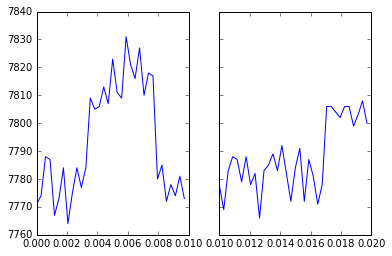

In [28]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

index_of_segment = 0
data = retrieve_ts('oxygen_concentration')
segment = get_segment_of_ts(data, 0, 34)
X = segment[:,1]
y = segment[:,0]

ax1.plot(X,y)

index_of_segment = 0

print("ts_label =", 'oxygen_concentration', "; index_of_segment =", index_of_segment)

data = retrieve_ts('oxygen_concentration')
segment = get_segment_of_ts(data, 1, 34)
X = segment[:,1]
y = segment[:,0]
ax2.plot(X,y)
plt.show()



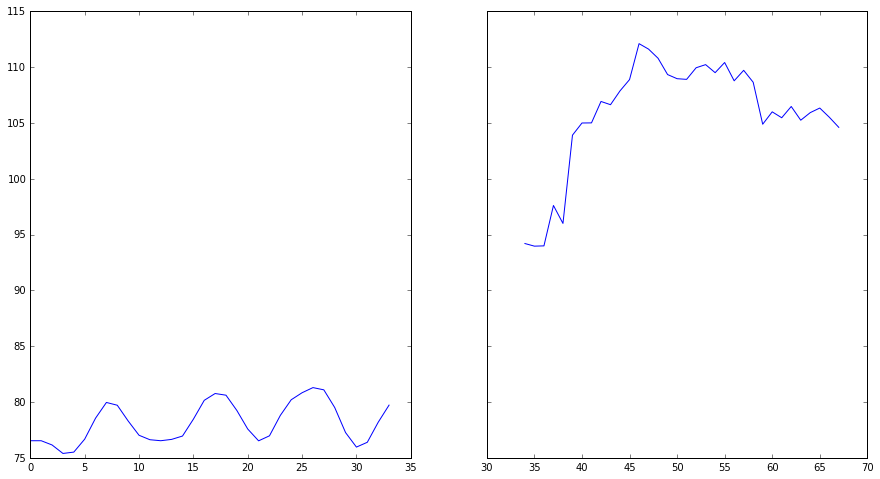

In [41]:
file = open('/home/kuluandrej/Ipython3_notebook_projects/MVR_py/ts_processing/heart_rate.txt', 'r')
data = np.loadtxt(file) 
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figheight(8)
f.set_figwidth(15)
num_seg = 0
num_rows = 34
ax1.plot(data[num_seg * num_rows : num_seg * num_rows + num_rows,])
num_seg = 1
ax2.plot(data[num_seg * num_rows : num_seg * num_rows + num_rows,])


In [28]:
np.savetxt('/home/kuluandrej/Ipython3_notebook_projects/MVR_py/ts_processing/open_apple_full.txt', backup_time_series[:], fmt = '%.4f')

ts_label = chest_volume ; index_of_segment = 0


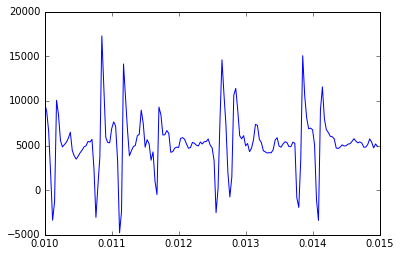

In [51]:
index_of_segment = 0
print("ts_label =", ts_labels[0], "; index_of_segment =", index_of_segment)
data = retrieve_ts(ts_labels[0])
segment = get_segment_of_ts(data, 2, int(data.shape[0] / 200))
X = segment[:,1]
y = segment[:,0]
plt.plot(X,y)
plt.show()

In [5]:
def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):    
    return [ atoi(c) for c in re.split('(\d+)', text) ]

files_path = 'populations/first_segments2/'
file_names = sorted(os.listdir(files_path), key=natural_keys)
files_path_dest = 'populations/first_segments3/'

if not os.path.isdir(files_path_dest):
    os.makedirs(files_path_dest)

    
for file in file_names:
    number_of_file = int(file[:-4].split('_')[-1])
    if number_of_file >= 51:
        os.rename(files_path + file, files_path_dest + file)

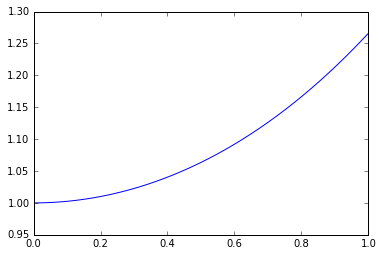

In [33]:
x = np.arange(0,1,.002)
y = np.i0(x)
plt.plot(x,y)

Script dealing with data removing from 'init_models'

In [35]:
file = open('/home/kuluandrej/Ipython3_notebook_projects/MVR_py/data/init_models.txt', 'r')
lines = file.readlines()
file.close()
file = open('/home/kuluandrej/cafedra2015-2016/Experiments on Machine Learning/Datasets/WIKI-AAPL.csv', 'w')
file_dest = open()
required_rows = 5000
for i in range(required_rows):
    file.write(lines[i])
file.close()